# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport mc.util 
from util import *
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import os
import pyximport; pyximport.install()

plt.style.use('seaborn-v0_8-ticks')
matplotlib.rcParams["mathtext.fontset"] = "cm"

os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang -shared'

# T=0

## Monomers

NameError: name 'data1' is not defined

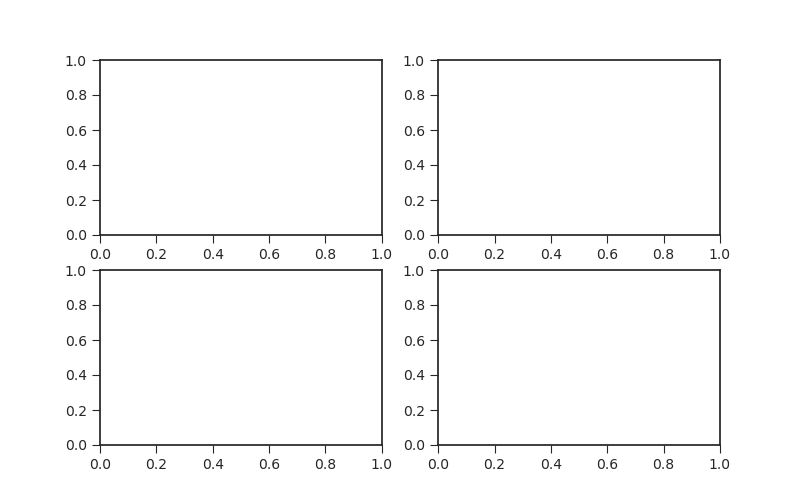

In [2]:
# data1 = read_accumulator("data/t0j0/doped/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((120, 120))

# data1 = read_accumulator("data/t0j0/doped2/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped2/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

# data1 = read_accumulator("new-data/t0j0/84x84_r-3_t0.000000_j0.000_200000000.20_1/mono-mono.dat", skip=10)[0].reshape((84, 84))
# data1 = read_accumulator("new-data/t0j0/96x96_r-3_t0.000000_j0.000_200000000.10_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
# data2 = read_accumulator("new-data/t0j0/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))
# data2 = read_accumulator("new-data/t0j0-ergodic/120x120_r-6_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

fig, ax = plt.subplots(2, 2, figsize=[8, 5])
plot2d(ax[0, 0], data1)
plot2d(ax[0, 1], data2)

def mod(data, x, y):
    return data.T[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data):
    lin = [0]
    xs = np.arange(data.shape[0]//2)
    for i in range(1, data.shape[0]//2):
        total = 0
        total += mod(data, 0, i)
        total += mod(data, i, 0)
        total += mod(data, -i, i)
        total += mod(data, -i, 0)
        total += mod(data, -i, -i)
        total += mod(data, i, -i)
        lin.append(total / 6)
    lin = np.array(lin)

    L = data.shape[0]
    xs = np.sin(np.pi/L * xs) / (np.pi/L)

    indices = np.arange(len(xs))
    return xs[indices % 3 != 0], lin[indices % 3 != 0]

def fit(xs, ys):
    import scipy

    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 0.002])

    return fun, param

x1, y1 = symmetrize(data1)
fun, param = fit(x1[:], y1[:])
ax[1, 0].scatter(x1, y1)
ax[1, 0].plot(x1, fun(x1, *param), label=f"B={param[0]}")
# ax[1, 0].set_yscale("log")
# ax[1, 0].set_xscale("log")
ax[1, 0].legend()

x2, y2 = symmetrize(data2)
fun, param = fit(x2[:], y2[:])
ax[1, 1].scatter(x2, y2)
ax[1, 1].plot(x2, fun(x2, *param), label=f"B={param[0]}")
# ax[1, 1].set_yscale("log")
# ax[1, 1].set_xscale("log")
ax[1, 1].legend()

### CFT scaling collapse

In [213]:
# L, data, N = get_all_data("new-data/infinite-u/pt/*t0.82*.20*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)
L, data, N = get_all_data("new-data/t0j0/*r-3*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)

merged_data = {}
for l, d, n in zip(L, data, N):
    if l > 12:
        if l not in merged_data:
            # take horizontal cut
            merged_data[l] = (d[:, 0], n)
        else:
            prev_n = merged_data[l][1]
            merged_data[l] = ((merged_data[l][0] * prev_n + d[:, 0] * n) / (prev_n + n), prev_n + n)

L, data, N = get_all_data("new-data/t0j0/*r-6*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)

merged_data2 = {}
for l, d, n in zip(L, data, N):
    if l > 12:
        if l not in merged_data2:
            # take horizontal cut
            merged_data2[l] = (d[:, 0], n)
        else:
            prev_n = merged_data2[l][1]
            merged_data2[l] = ((merged_data2[l][0] * prev_n + d[:, 0] * n) / (prev_n + n), prev_n + n)

L = L[L>12]

-0.2509529198884517 0.0008662588723200201
-0.2439170089597874 0.0007150214668653733
0.4724632116205809 0.003581141842416388


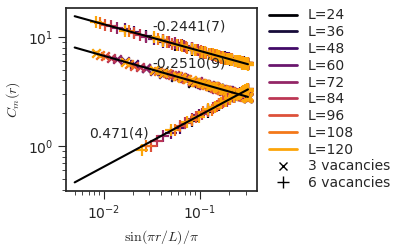

In [222]:
def plot(ax, merged_data, label=True):
    xs1 = []
    ys1 = []
    xs2 = []
    ys2 = []
    colors = gen_colors(L)

    for l, pair in merged_data.items():
        d, total_n = pair
        x = np.arange(l)
        scaledx = np.sin(np.pi * x/l) / (np.pi/l)
        scaledx = scaledx/l

        d = d * l**2
        labelstr = "L="+str(l) if label else None
        if d[3] > 0:
            ax.scatter(scaledx, d, marker="+", s=64, color=colors[l], label=labelstr)
        else:
            ax.scatter(scaledx[x%3!=0], d[x%3!=0], marker="x", color=colors[l], label=labelstr)

        for i in range(0, d.shape[0]//2):
            if i % 3 != 0:
                xs1.append(scaledx[i])
                ys1.append(d[i])
            else:
                xs2.append(scaledx[i])
                ys2.append(d[i])

    x = np.linspace(0.005, 1/np.pi, 100)

    # def fun(x, A, B, C):
    #     return B * np.exp(np.abs(x) / A) + C
    # param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1, 1/16], bounds=([-5, -np.inf, 0], [-0.01, np.inf, 100]))
    # plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")

    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, cov = scipy.optimize.curve_fit(fun, xs1, ys1, p0=[-0.25, 1], bounds=([-1, -np.inf], [0, np.inf]))
    # ax.plot(x, fun(x, *param), label=f"Fit $y\\sim x^{{{param[0]:.3f}}}$")
    ax.plot(x, fun(x, *param), color="k")
    print(param[0], np.sqrt(cov[0,0]))

    if np.mean(ys2) > 0.01:
        def fun(x, A, B):
            return B * np.power(np.abs(x), A)
        param, cov = scipy.optimize.curve_fit(fun, xs2, ys2, p0=[0.5, 1], bounds=([0, -np.inf], [1, np.inf]))
        # ax.plot(x, fun(x, *param), label=f"Fit $y\\sim x^{{{param[0]:.3f}}}$")
        ax.plot(x, fun(x, *param), color="k")
        print(param[0], np.sqrt(cov[0,0]))

    ax.set_ylabel("$C_m(r)$")
    ax.set_xlabel("$\\sin(\\pi r/L) / \\pi$")


plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=[4, 2.5], layout="constrained")
plot(ax, merged_data)
plot(ax, merged_data2, label=False)
plt.xscale('log')
plt.yscale('log')
plt.text(0.032, 11.5, "-0.2441(7)")
plt.text(0.032, 5.3, "-0.2510(9)")
plt.text(0.007, 1.2, "0.471(4)")

colors = gen_colors(L)

custom_lines = [matplotlib.lines.Line2D([0], [0], color=colors[l], lw=2) for l in L]
custom_labels = ["L="+str(l) for l in L]

custom_lines.append(matplotlib.lines.Line2D([0], [0], color="k", marker="x", ls='none'))
custom_labels.append("3 vacancies")
custom_lines.append(matplotlib.lines.Line2D([0], [0], color="k", marker="+", markersize=8, ls='none'))
custom_labels.append("6 vacancies")

# box = ax.get_position()
ax.legend(custom_lines, custom_labels, loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=0.2)
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.savefig("figures/monomer-exp.png", dpi=200)

### g renormalization

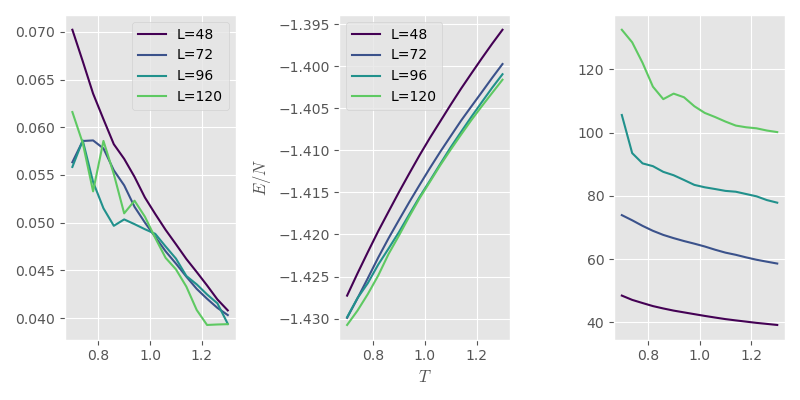

In [6]:
fig, ax = plt.subplots(1, 3, figsize=[8, 4])
skip=100000

Ls = [48, 72, 96, 120]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["bw"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/infinite-u/pt/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label="L="+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/infinite-u/pt/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label="L="+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_data(f"new-data/infinite-u/pt/{l}*/order.dat", lambda data, props: data[0][0], skip=skip)
        ax[2].plot(ts2, ds2, label="L="+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel("$E/N$")
ax[1].set_xlabel("$T$")
plt.tight_layout()

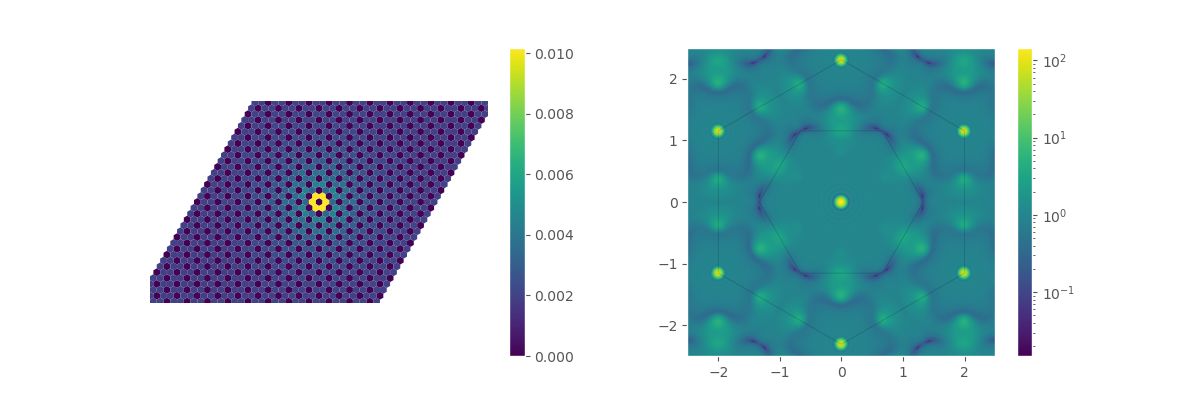

In [11]:
l=36
fig, ax = plt.subplots(1, 2, figsize=[12, 4])
L, data, N = get_all_data(f"new-data/infinite-u/pt/{l}x{l}*t1.0*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)
plot2d(ax[0], data[0])
L, data, N = get_all_data(f"new-data/infinite-u/pt/{l}x{l}*t1.0*/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=10000, by="l", with_counts=True)
plot_FT(ax[1], FT_hex(data[0]), proj="logabs")

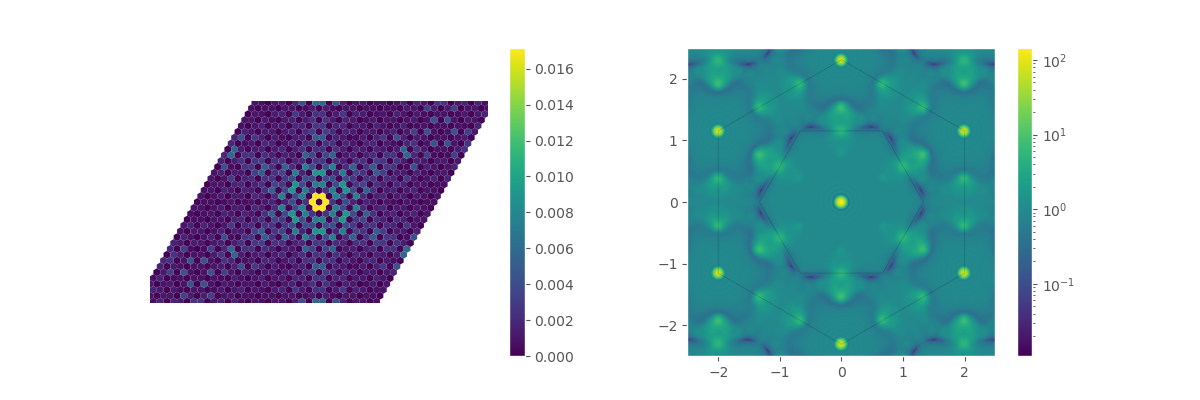

In [97]:
l=36
fig, ax = plt.subplots(1, 2, figsize=[12, 4])
L, data, N = get_all_data(f"new-data/infinite-u/-1/{l}x{l}*t0.5*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)
plot2d(ax[0], data[0])
L, data, N = get_all_data(f"new-data/infinite-u/-1/{l}x{l}*t0.5*/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=10000, by="l", with_counts=True)
plot_FT(ax[1], FT_hex(data[0]), proj="logabs")

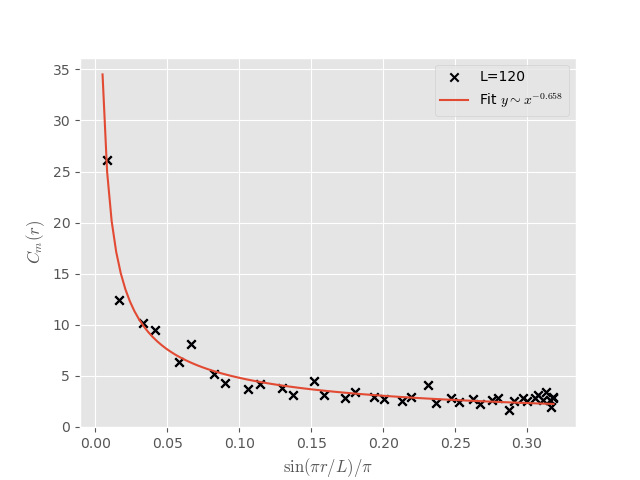

In [113]:
plt.figure()
l = 120
L, data, N = get_all_data(f"new-data/infinite-u/-1/{l}x{l}*t1.5*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)
merged_data = {l: (data[0][:, 0], 1)}
plot(plt.gca(), merged_data)

# L, data, N = get_all_data("new-data/infinite-u/-1/72x72*t5.*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)
# merged_data = {72: (data[0][:, 0], 1)}
# plot(plt.gca(), merged_data)

In [12]:
glob = "new-data/infinite-u/pt/72x72*"
ts, data, N = get_all_data(glob + "/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=00000, by="t", with_counts=True)
ts, mono, N = get_all_data(glob + "/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=00000, by="t", with_counts=True)
ts, order, N = get_all_data(glob + "/order.dat", lambda data, props: data[0], skip=00000, by="t", with_counts=True)

Text(0.5, 0, 'T')

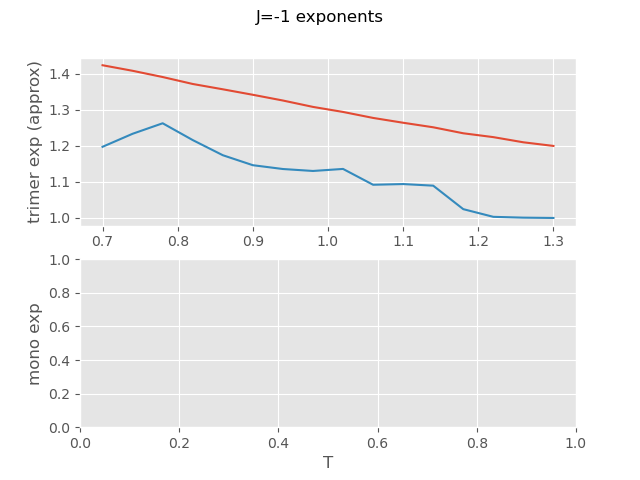

In [13]:
xs = []
exps = []
monoexps = []
for t, d, m, o in zip(ts, data, mono, order):
    xs.append(t)

    d = d[:36, 0, 0]
    scaledx = np.sin(np.arange(36) * np.pi / 72) * 36
    offset = 3
    def fun(x, A, B):
        return B * np.power(np.abs(x), A) + 1/6
    param, _ = scipy.optimize.curve_fit(fun, scaledx[offset::3], d[offset::3], p0=[-0.25, 1], bounds=([-4, -np.inf], [0, np.inf]))
    exps.append(param[0])

    m = m[:36, 0]
    nonzero = m>0
    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, scaledx[nonzero], m[nonzero], p0=[-0.25, 1], bounds=([-4, -np.inf], [0, np.inf]))
    monoexps.append(param[0])

fig, ax = plt.subplots(2, 1)
ax[0].plot(xs, (exps / exps[-1])**-1 * 1.2, label="mono exp")
ax[0].plot(xs, monoexps / monoexps[-1], label="trimer exp")

plt.suptitle("J=-1 exponents")
ax[0].set_ylabel("trimer exp (approx)")
ax[1].set_ylabel("mono exp")
ax[1].set_xlabel("T")
# plt.plot(xs, orders)

# x = np.linspace(3, 30, 100)
# plt.plot(xs, data)
# plt.plot(x, fun(x, *param), label=f"Fit $y\\sim x^{{{param[0]:.3f}}}$")
# plt.legend()

## Trimers

### Scaling

In [197]:
L, data, N = get_all_data("new-data/t0j0/*r-3*/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=500000, by="l", with_counts=True)
# L, data, N = get_all_data("new-data/infinite-u/pt/*t0.8*/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=100000, by="l", with_counts=True)
# L, data, N = get_all_data("new-data/t0j0-ergodic/*r-3*/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=400000, by="l", with_counts=True)

merged_data = {}
for l, d, n in zip(L, data, N):
    if l > 12:
        if l not in merged_data:
            merged_data[l] = (d[:, :, :], n)
        else:
            prev_n = merged_data[l][1]
            merged_data[l] = ((merged_data[l][0] * prev_n + d[:, :, :] * n) / (n + prev_n), n + prev_n)
L = L[L>12]

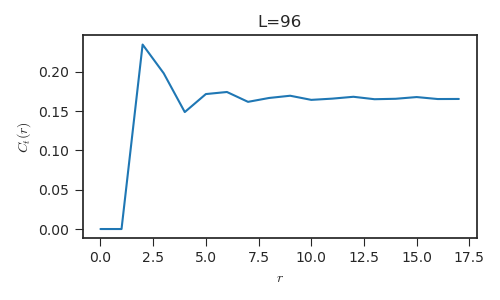

In [189]:
plt.figure(figsize=[5, 3])
plt.plot(merged_data[36][0][:18, 0, 0])
plt.xlabel("$r$")
plt.ylabel("$C_t(r)$")
plt.title("L=96")
plt.tight_layout()

0.16532011262730353
-2.1722511516373744 0.16532011262730353
0.1948011463658366
-2.0560347649745716 0.1948011463658366


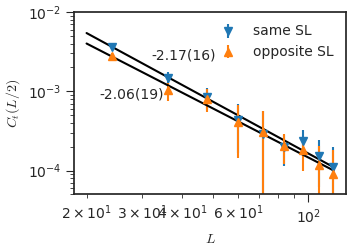

In [210]:
def fit(xs, ys, yerr):
    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, cov = scipy.optimize.curve_fit(fun, xs, ys, sigma=yerr, absolute_sigma=True, p0=[-2, 0.001])
    
    # jackknife = []
    # for i in range(len(xs)-5):
        # newxs = np.concatenate((xs[:i], xs[i+1:]))
        # newys = np.concatenate((ys[:i], ys[i+1:]))
        # newxs = xs[i:]
        # newys = ys[i:]
        # param, cov = scipy.optimize.curve_fit(fun, newxs, newys, p0=[-2, 0.001])
        # jackknife.append(param[0])
    # print(jackknife)
    # print(np.std(jackknife))

    print(np.sqrt(cov[0, 0]))
    return fun, param, np.sqrt(cov[0,0])

values = []
values2 = []
ns = []
ls = []
for l, pair in merged_data.items():
    d, n = pair
    ls.append(l)
    values.append(d[l//2, 0, 0])
    values2.append(d[l//2, 0, 1])
    ns.append(n)

ls = np.array(ls)
densities = (ls*ls/3-1)/(ls*ls*2)
# densities = (ls*ls/3-1)/(ls*ls*2)

values = np.array(values) - densities
values2 = -(np.array(values2) - densities)
ns = np.array(ns)

fig, ax = plt.subplots(1, 1, figsize=[3.5, 2.5], layout="constrained")
xs = np.linspace(20, 120, 30)

autocorr = 20
n_per_sample = 20
yerr = np.sqrt((values+densities)*(1-densities-values))/np.sqrt(ns*n_per_sample/autocorr)
plt.errorbar(ls, values, yerr=yerr, ls="", marker="v", label="same SL")
fun, param, err = fit(ls, values, yerr)
plt.plot(xs, fun(xs, *param), color="k") #, label=f"$y\\sim x^{{{param[0]:.3f}}}$")
print(param[0], err)
plt.text(32, 0.0025, "-2.17(16)")

yerr = np.sqrt((values2+densities)*(1-densities-values2))/np.sqrt(ns*n_per_sample/autocorr)
plt.errorbar(ls, values2, yerr=yerr, ls="", marker="^", label="opposite SL")
fun, param, err = fit(ls, values2, yerr)
plt.plot(xs, fun(xs, *param), color="k") #, label=f"$y\\sim x^{{{param[0]:.3f}}}$")
print(param[0], err)
plt.text(22, 0.0008, "-2.06(19)")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("$L$")
plt.ylabel("$C_t(L/2)$")
plt.ylim([0.00005, 0.01])

plt.savefig("figures/trimer-exp.png", dpi=200)

## Entropy per trimer

/tmp/ipykernel_1733972/2729964750.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  entropies.append(scipy.integrate.quad(fun, ts2[0], ts2[-1], limit=200)[0])


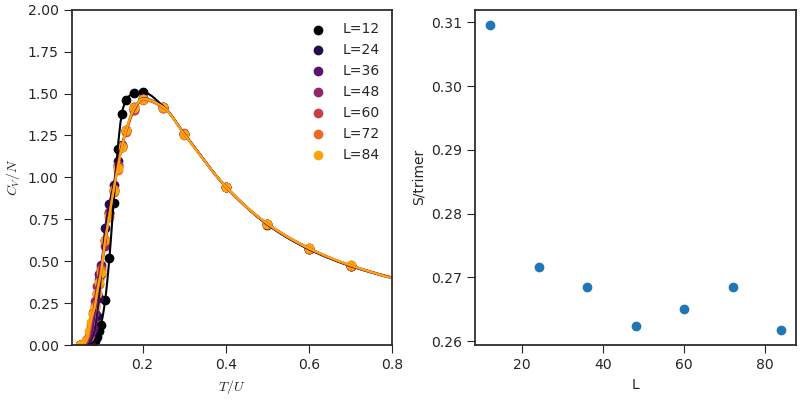

In [76]:
plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=[8, 4], layout="constrained")
ax[0].set_ylabel("$C_V/N$")
ax[0].set_xlabel("$T/U$")
ax[0].set_xlim([0.03, 0.8])
ax[0].set_ylim([0, 2])

skip = 300000
ls = [12, 24, 36, 48, 60, 72, 84]
entropies = []
colors = gen_colors(ls)
for L in ls:
    ts1, ds1 = get_all_cvs(f"new-data/vsweeps/single/0/{L}x{L}_r-0_t*_j0.000_20000000.20_0/energy.dat", skip=skip)

    interp = lambda x: np.piecewise(x, [x<0.06, (0.06<=x)*(x<50), 50<=x], [0, scipy.interpolate.PchipInterpolator(ts1, ds1), 0])
    # interp = lambda x: scipy.interpolate.splev(x, scipy.interpolate.splrep(ts1, ds1, s=0.002))

    fun = lambda x: interp(x) / x

    ts2 = np.geomspace(np.amin(ts1), np.amax(ts1), 200)
    entropies.append(scipy.integrate.quad(fun, ts2[0], ts2[-1], limit=200)[0])

    ax[0].scatter(ts1, ds1, label="L="+str(L), color=colors[L])
    ax[0].plot(ts2, interp(ts2), color=colors[L])

ls = np.array(ls)
entropies = np.array(entropies)
ax[0].legend()

def S(n):
    return 6 * np.log(6) - 5 * np.log(5) - 1/2/n * np.log(5*np.pi*n/3)
ax[1].scatter(ls, S(ls**2/3)-entropies)
ax[1].set_xlabel("L")
ax[1].set_ylabel("S/trimer")

def fun(x, A, B):
    return A + B/x
# param, _ = scipy.optimize.curve_fit(fun, ls[:-1], S(ls[:-1]**2/3)-entropies[:-1])
# xs =np.linspace(6, 84, 20)
# ax[1].plot(xs, fun(xs, *param))
# print(param)

In [60]:
s = [2.5375322447393675e-07, 0.0002619504157933521, 0.0008942641762712954, 0.001827334277366176, 0.0030241023155366045, 0.004459217009761929, 0.006113654206647964, 0.007972409965534522, 0.010023285581997285, 0.012256165956927464, 0.014662555505917756, 0.017235262202248525, 0.01996817377198561, 0.022856093952619762, 0.02589462032162287, 0.029080051802198772, 0.032409318154056566, 0.03587992651300273, 0.039489921320305175, 0.04323785542563304, 0.04712277070854076, 0.05114418720734576, 0.055302100174855415, 0.05959698485439984, 0.06402980911095314, 0.06860205439156807, 0.0733157458570424, 0.07817349295354199, 0.08317854221682874, 0.08833484477399874, 0.09364714189763196, 0.09912107325836259, 0.10476331358042579, 0.11058174801006226, 0.11658569560221502, 0.12278620103799444, 0.12919641822617334, 0.1358321241183866, 0.14271242052077526, 0.14986071562548536, 0.15730613574284213, 0.1650856256406995, 0.17324720494596366, 0.1818552830877214, 0.190999923407219, 0.2008144635028872, 0.211513388925136, 0.22349043660578133, 0.23767377313820812, 0.25973586920412844]

In [74]:
np.log(np.sum(np.exp(np.array(s)*2000)))/2000

0.25973586920412844

# T>0

## Strong transitions

### J=0.01

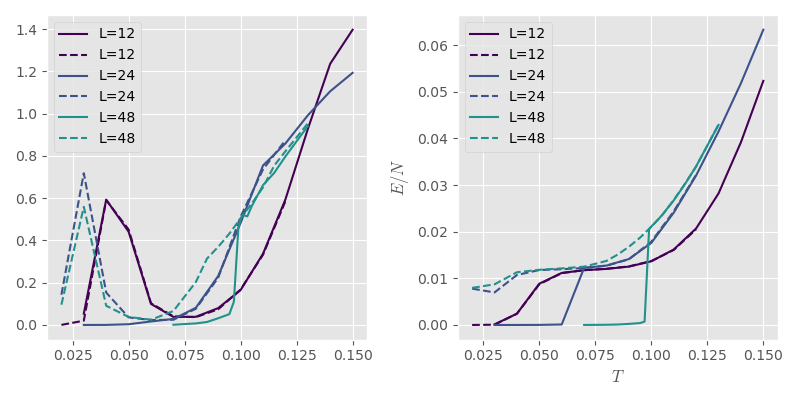

In [24]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
skip=100000

Ls = [12, 24, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["rt3", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label="L="+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label="L="+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel("$E/N$")
ax[1].set_xlabel("$T$")
plt.tight_layout()

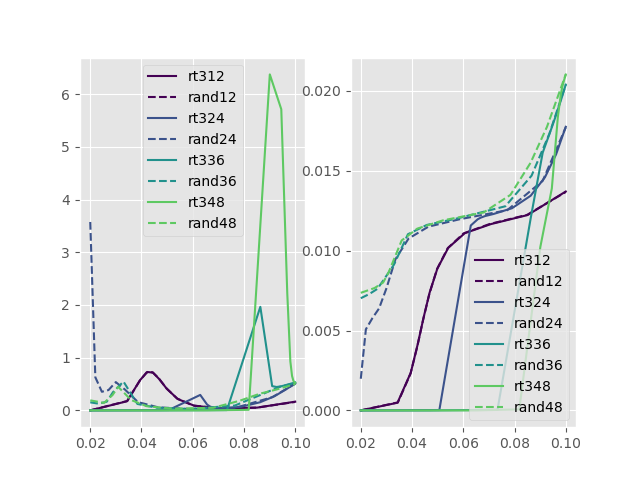

In [29]:
fig, ax = plt.subplots(1, 2)
skip=0

Ls = [12, 24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["rt3", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/pto/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/pto/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

### J=-0.1

In [ ]:
fig, ax = plt.subplots(1, 2)
skip=100000

Ls = [24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["bw", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/vsweeps/rough/-0.1/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/vsweeps/rough/-0.1/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

### Structure factor evolution

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])

for i, t in enumerate([0.33, 0.335579, 0.346369, 0.348]):
    data = read_accumulator(f"new-data/vsweeps/binder/2/48x48_r-0_t{t:.6f}_j2.000_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot2d_hex(ax[0, i], data)
    plot_FT(ax[1, i], FT_hex(data), proj="logabs")
    ax[0, i].set_title(f"t={t}")
fig.suptitle("J=2 L=48")

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])

for i, t in enumerate([0.265, 0.278170, 0.281064, 0.29]):
    data = read_accumulator(f"new-data/vsweeps/binder/0.3/48x48_r-0_t{t:.6f}_j0.300_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot2d_hex(ax[0, i], data)
    plot_FT(ax[1, i], FT_hex(data), proj="logabs")
    ax[0, i].set_title(f"t={t}")
fig.suptitle("J=0.3 L=48")

Text(0.5, 0.98, 'J=0.01 L=48')

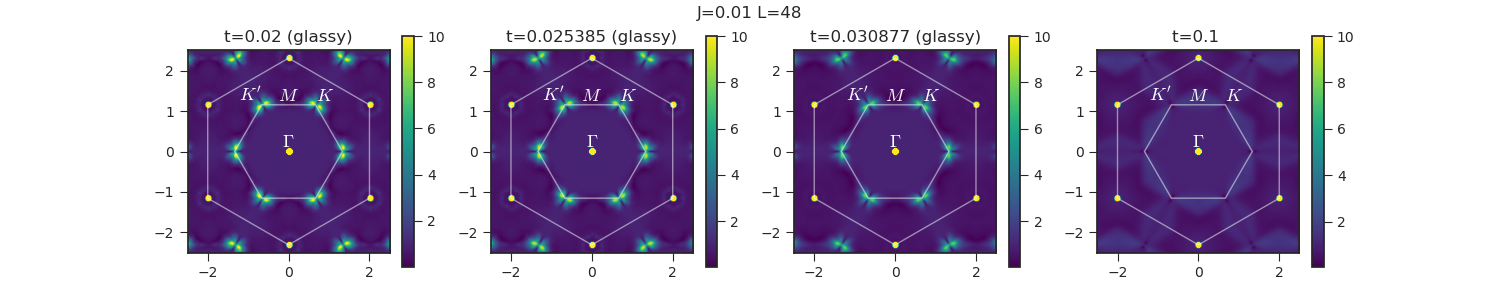

In [46]:
fig, ax = plt.subplots(1, 4, figsize=[15, 3])

for i, t in enumerate([0.02, 0.025385, 0.030877, 0.1]):
    data = read_accumulator(f"new-data/pto/0.01/rand/48x48_r-0_t{t:.6f}_j0.010_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot_FT(ax[i], FT_hex(data), proj="abs", vmax=10)
    if t<0.05:
        suffix = "(glassy)"
    else:
        suffix = ""
    ax[i].set_title(f"t={t} {suffix}")
fig.suptitle("J=0.01 L=48")

Text(0.5, 0.98, 'J=-0.1 L=48')

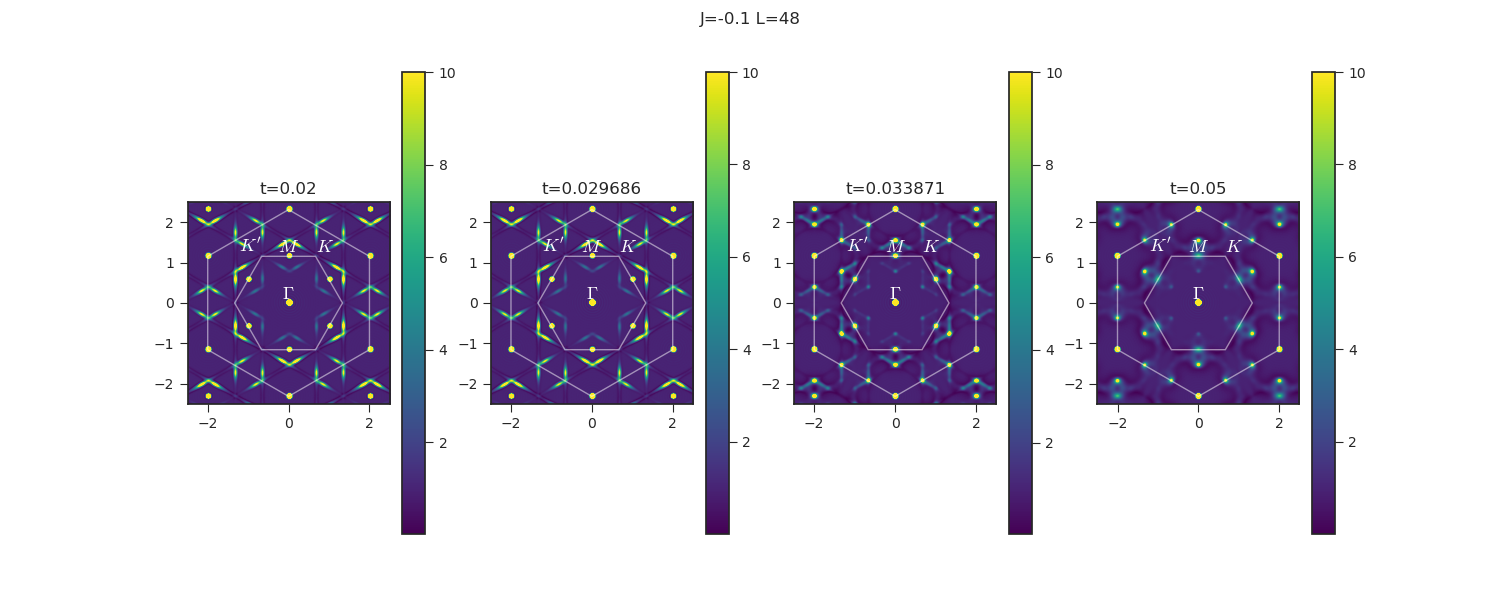

In [41]:
fig, ax = plt.subplots(1, 4, figsize=[15, 3])

for i, t in enumerate([0.02, 0.029686, 0.033871, 0.05]):
    data = read_accumulator(f"new-data/pto/-0.1/48x48_r-0_t{t:.6f}_j-0.100_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot_FT(ax[i], FT_hex(data), proj="abs", vmax=10)
    ax[i].set_title(f"t={t}")
fig.suptitle("J=-0.1 L=48")

Text(0.5, 0.98, 'J=0 L=48')

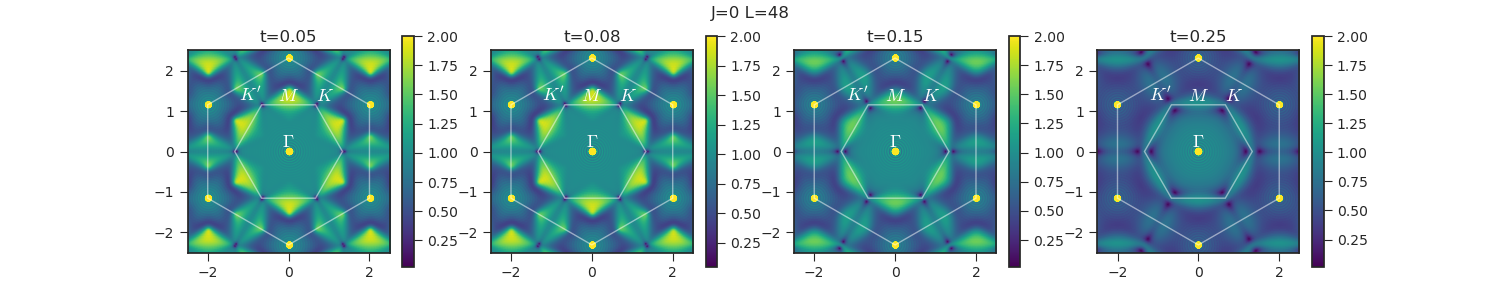

In [45]:
fig, ax = plt.subplots(1, 4, figsize=[15, 3])

for i, t in enumerate([0.05, 0.08, 0.15, 0.25]):
    data = read_accumulator(f"new-data/vsweeps/single/0/48x48_r-0_t{t:.6f}_j0.000_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot_FT(ax[i], FT_hex(data), proj="abs", vmax=2)
    ax[i].set_title(f"t={t}")
fig.suptitle("J=0 L=48")

Text(0.5, 0.98, 'J=-0.01 L=72')

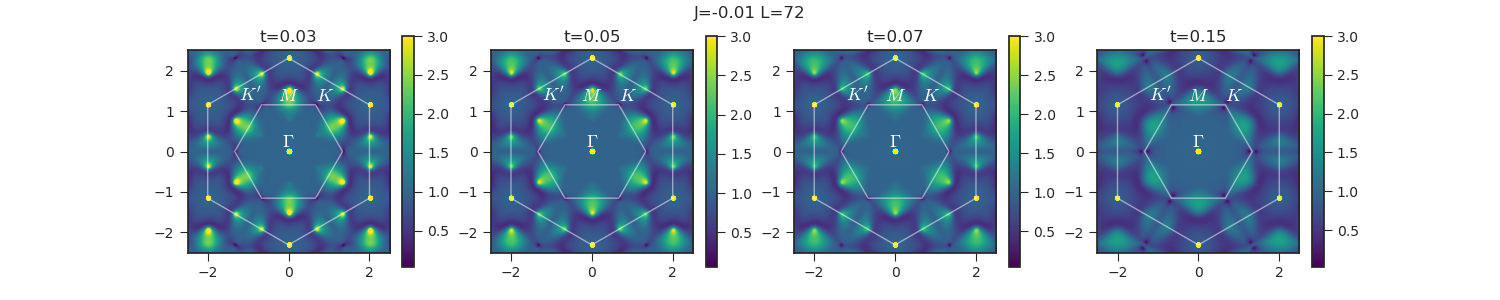

In [51]:
fig, ax = plt.subplots(1, 4, figsize=[15, 3])

for i, t in enumerate([0.03, 0.05, 0.07, 0.15]):
    data = read_accumulator(f"new-data/finite-t/j-0.01/72x72_r-3_t{t:.6f}_j-0.010_20000000.20_0/tri-tri.dat")[0].reshape((72, 72, 2))
    plot_FT(ax[i], FT_hex(data), proj="abs", vmax=3)
    ax[i].set_title(f"t={t}")
fig.suptitle("J=-0.01 L=72")

## Horizontal sweeps

In [ ]:
skip=10000
fig, ax = plt.subplots(1, 3)
j4, cv = get_all_cvs("new-data/hsweeps/0.1/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.10")
j4, cv = get_all_cvs("new-data/hsweeps/0.07/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.07")
j4, cv = get_all_cvs("new-data/hsweeps/0.05/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.05")
ax[0].legend()

j4, cv = get_all_data("new-data/hsweeps/0.1/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])
j4, cv = get_all_data("new-data/hsweeps/0.07/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])
j4, cv = get_all_data("new-data/hsweeps/0.05/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])

In [ ]:
data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j-0.250_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 3)
plot2d_hex(ax[0,0], data)
plot_FT(ax[1,0], FT_hex(data), proj="logabs")

data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j-0.025_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
plot2d_hex(ax[0,1], data)
plot_FT(ax[1,1], FT_hex(data), proj="logabs")

data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j0.000_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
plot2d_hex(ax[0,2], data)
plot_FT(ax[1,2], FT_hex(data), proj="logabs")

## Trimer structure factor

Text(0.5, 1.0, 'J=-0.1 T=0.05 48x48')

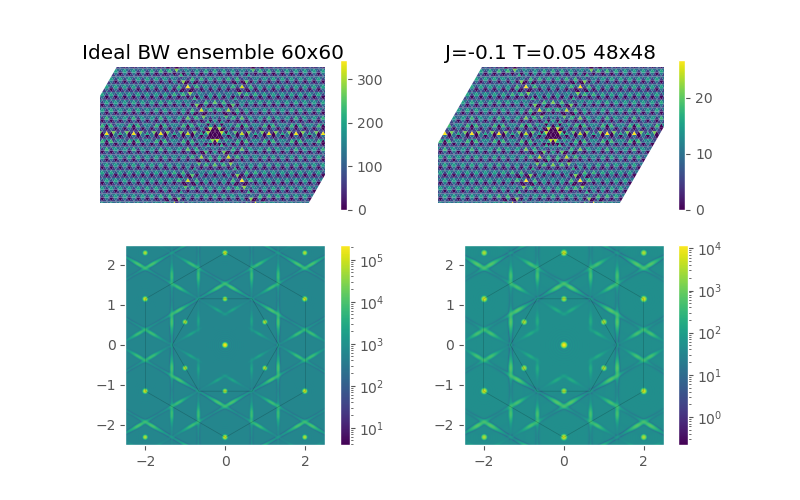

In [52]:
data1 = read_accumulator("data/idealbw/60x60_r-3_uinf_4j0.00_1000.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/-0.1/48x48_r-0_t0.0300_j-0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal BW ensemble 60x60")
ax[0,1].set_title("J=-0.1 T=0.05 48x48")

Text(0.5, 1.0, 'J=0.1 T=0.09 48x48')

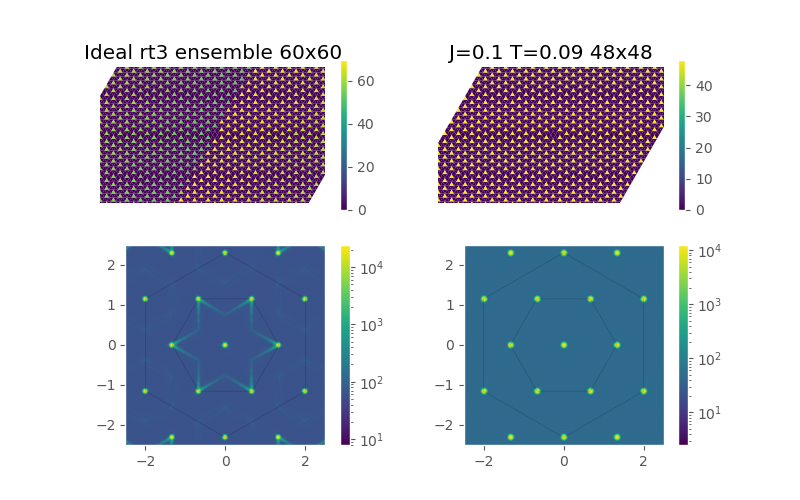

In [160]:
data1 = read_accumulator("data/idealrt3/60x60_r-0_t0.000000_j0.000_10.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/0.1/48x48_r-0_t0.0900_j0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal rt3 ensemble 60x60")
ax[0,1].set_title("J=0.1 T=0.09 48x48")

In [74]:
data1 = read_accumulator("data/rt3trans/48x48_r-3_uinf_4j0.00_20000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
data2 = read_accumulator("data/vsweeps/0.01/48x48_r-0_t0.5000_j0.0100_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("T=0 J=0 48x48")
ax[0,1].set_title("T=0.5 J=0 48x48")

data/rt3trans/48x48_r-3_uinf_4j0.00_20000000.5_0/tri-tri.dat


FileNotFoundError: [Errno 2] No such file or directory: 'data/rt3trans/48x48_r-3_uinf_4j0.00_20000000.5_0/tri-tri.dat'

## Restricted mobility and confinement

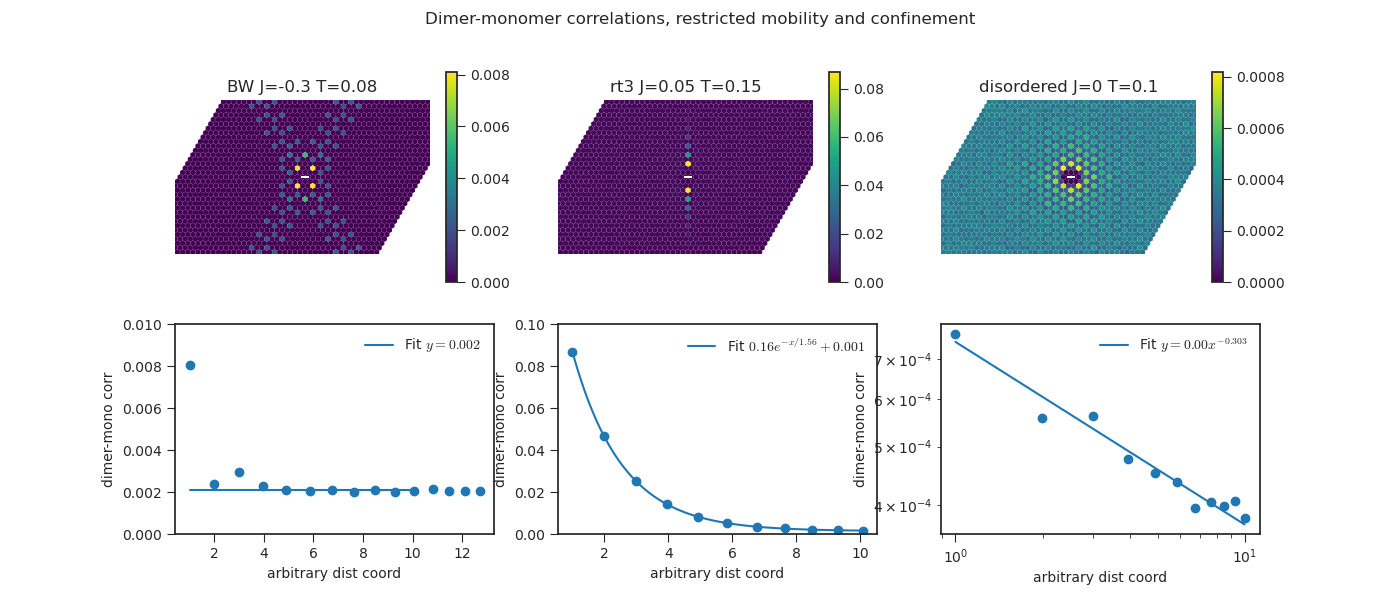

In [42]:
fig, ax = plt.subplots(2, 3, figsize=[14, 6])

fig.suptitle("Dimer-monomer correlations, restricted mobility and confinement")

data1 = read_accumulator("new-data/finite-t/j-0.3t0.08/48x48_r-3_t0.080000_j-0.300_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,0], data1, show_dimer=True)
ax[0,0].set_title("BW J=-0.3 T=0.08")

data2 = read_accumulator("new-data/finite-t/j0.05t0.15/48x48_r-3_t0.150000_j0.050_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,1], data2, show_dimer=True)
ax[0,1].set_title("rt3 J=0.05 T=0.15")

data3 = read_accumulator("new-data/finite-t/j0/48x48_r-3_t0.100000_j0.000_20000000.20_1/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,2], data3, show_dimer=True)
ax[0,2].set_title("disordered J=0 T=0.1")

def mod(data, x, y):
    return data[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data, cut):
    if cut == "perp":
        xs = np.arange(data.shape[0]//4)
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ys[i] = np.mean([mod(data, -i, 1+2*i), mod(data, 1+i, -1-2*i)][0])
    else:
        xs = np.arange(2*(data.shape[0]//6))
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ii = i // 2
            if i % 2 == 0:
                ys[i] = np.mean([mod(data, 0, 1+3*ii), mod(data, -3*ii, 1+3*ii),
                                 mod(data, 1+3*ii, -1-3*ii), mod(data, 1, -1-3*ii)])
            else:
                ys[i] = np.mean([mod(data, 1, 2+3*ii), mod(data, -2-3*ii, 2+3*ii),
                                 mod(data, 3+3*ii, -2-3*ii), mod(data, 0, -2-3*ii)])
    
    xs = np.sin(np.pi * xs/data.shape[0]) / (np.pi/data.shape[0]) 
    return xs[1:], ys[1:]

x = np.linspace(1, 10, 100)

xs, ys = symmetrize(data1, "zigzag")
ax[1, 0].scatter(xs, ys)
def fun(x, A):
    return np.ones_like(x) * A

param, _ = scipy.optimize.curve_fit(fun, xs[3:], ys[3:])
ax[1, 0].plot(x, fun(x, *param), label=f"Fit $y={param[0]:.3f}$")
ax[1, 0].set_xlabel("arbitrary dist coord")
ax[1, 0].set_ylabel("dimer-mono corr")
ax[1, 0].set_ylim([0, 0.01])
ax[1, 0].legend()

xs, ys = symmetrize(data2, "perp")
ax[1, 1].scatter(xs, ys)
def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1, 0])
ax[1, 1].plot(x, fun(x, *param), label=f"Fit ${param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")
ax[1, 1].set_xlabel("arbitrary dist coord")
ax[1, 1].set_ylabel("dimer-mono corr")
ax[1, 1].set_ylim([0, 0.1])
ax[1, 1].legend()

xs, ys = symmetrize(data3, "perp")
ax[1, 2].scatter(xs, ys)
def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1], bounds=([-5, 0], [-0.01, np.inf]))
ax[1, 2].plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}x^{{{param[0]:.3f}}}$")
ax[1, 2].set_yscale("log")
ax[1, 2].set_xscale("log")
ax[1, 2].set_ylabel("dimer-mono corr")
ax[1, 2].set_xlabel("arbitrary dist coord")
ax[1, 2].legend()

Text(0.5, 1.0, 'dis J=0 T=0.10')

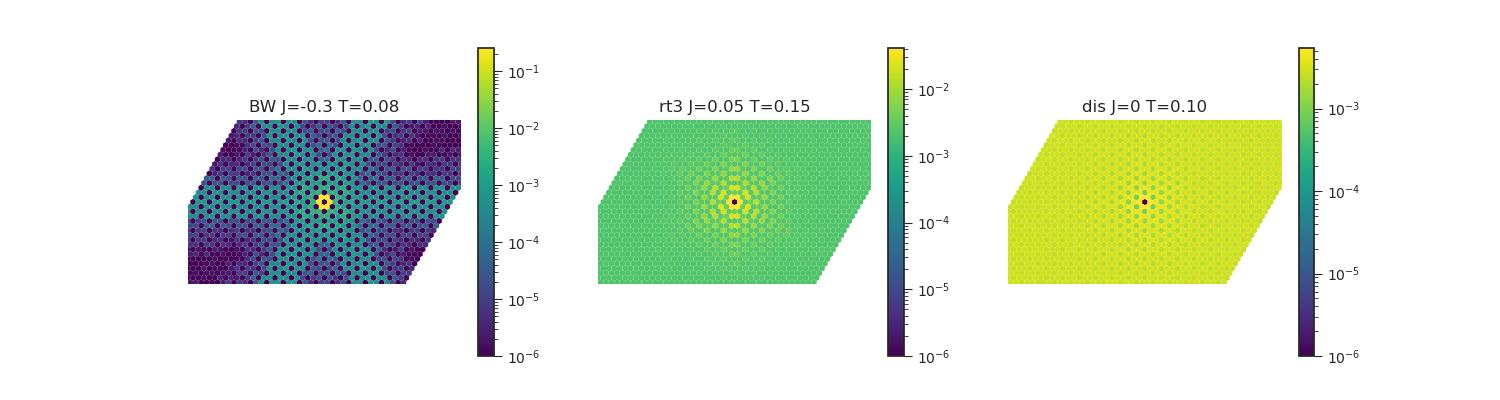

In [53]:
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
data1 = read_accumulator("new-data/finite-t/j-0.3t0.08/48x48_r-3_t0.080000_j-0.300_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0], data1, log=True)
ax[0].set_title("BW J=-0.3 T=0.08")

data1 = read_accumulator("new-data/finite-t/j0.05t0.15/48x48_r-3_t0.150000_j0.050_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[1], data1, log=True)
ax[1].set_title("rt3 J=0.05 T=0.15")

data1 = read_accumulator("new-data/finite-t/j0/48x48_r-3_t0.100000_j0.000_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[2], data1, log=True)
ax[2].set_title("dis J=0 T=0.10")

## CFT scaling hypothesis

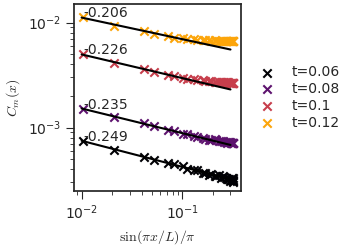

In [40]:
T, data = get_all_data("new-data/finite-t-ergodic/*/96*_0/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=100, by="t")

plt.figure(figsize=[3.5, 2.5], layout="constrained")
xs = []
ys = []
colors = gen_colors(T[(T<=0.12)*(T>=0.06)])
for t, d in zip(T, data):
    if t > 0.12: continue
    if t < 0.06: continue

    l = d.shape[0]
    x = np.arange(l)
    scaledx = np.sin(np.pi * x / l) / np.pi

    plt.scatter(scaledx[(x%3!=0)*(x<l//2)], d[(x%3!=0)*(x<l//2), 0], marker="x", label="t="+str(t), color=colors[t])

    xs = np.geomspace(0.01, 0.3, 100)
    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, scaledx[(x%3!=0)*(x<12)], d[(x%3!=0)*(x<12), 0])
    plt.plot(xs, fun(xs, *param), color="k")
    plt.text(scaledx[1], d[1, 0], f"{param[0]:.3f}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\sin (\\pi x / L) / \\pi$")
plt.ylabel("$C_m(x)$")
plt.ylim([0.00025, 0.015])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=0.2)
plt.savefig("figures/ft.png")

# Fixed Density

In [ ]:
plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=[12, 5])
skip=50000

colormap = {"0": "red", "1.12": "blue", "1.48": "green", "1.192": "purple", "1.6": "lime", "1.96": "pink"}

for d in colormap.keys():
    for init in ["rt3", "rand"]:
        l = 48
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/dsweeps/{d}/{init}/*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=str(l)+init+" "+d, ls=ls, color=colormap[d])
        ts2, ds2 = get_all_energies(f"new-data/dsweeps/{d}/{init}/*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=str(l)+init+" "+d, ls=ls, color=colormap[d])
        ts2, ds2 = get_all_data(f"new-data/dsweeps/{d}/{init}/*/energy.dat", lambda data, prop: 1-data[0][4]/3/data[0][3]**2, skip=skip)
        ax[2].plot(ts2, ds2, label=str(l)+init+" "+d, ls=ls, color=colormap[d])
ax[2].set_ylim([0, 1])
ax[0].set_ylim([0, 1])

ax[0].legend()
ax[1].legend()

## first order histograms

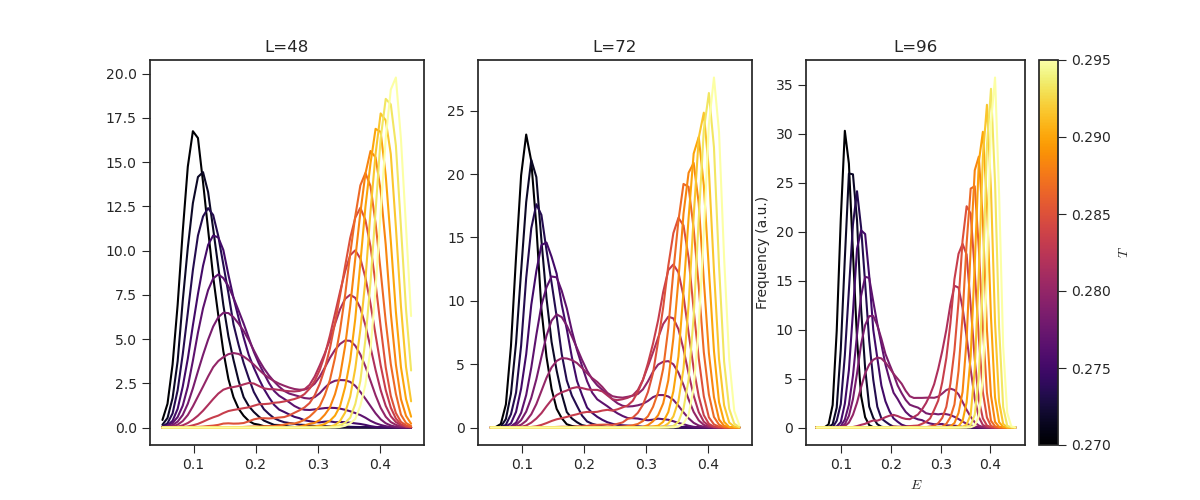

In [9]:
def show_hists(ax, files):
    import seaborn as sns
    for i, f in enumerate(sorted(enum_files(files), key=lambda f: f["t"])):
        e = np.genfromtxt(f["fname"], skip_header=0, max_rows=100000)
        l = f["l"]
        t = f["t"]
        j = f["j4"]
        kde = scipy.stats.gaussian_kde((e[:, 1]*j + e[:, 0])/l/l*3)
        xs = np.linspace(0.05, 0.45, 50)
        ax.plot(xs, kde(xs), color=matplotlib.colormaps["inferno"](i/15))

        # ax.hist((e[:, 1]*j + e[:, 0])/l/l*3, bins=50, histtype="step", density=True, lw=1, color=matplotlib.colormaps["inferno"](i/15))

fig, ax = plt.subplots(1, 3, figsize=[12, 5])

# show_hists(ax[0], "new-data/vsweeps/binder/0.4/84*/energy-single.dat")
# show_hists(ax[1], "new-data/vsweeps/binder/0.5b/84*/energy-single.dat")
# show_hists(ax[2], "new-data/vsweeps/binder/0.6b/84*/energy-single.dat")

# show_hists(ax[0], "new-data/ehist/0.1/48x48*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.1/72x72*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.1/96x96*/energy-single.dat")

show_hists(ax[0], "new-data/ehist/0.3/48*/energy-single.dat")
show_hists(ax[1], "new-data/ehist/0.3/72*/energy-single.dat")
show_hists(ax[2], "new-data/ehist/0.3/96*/energy-single.dat")

# show_hists(ax[0], "new-data/ehist/0.3/48*t0.275000*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.279933*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.280424*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.281543*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.293000*/energy-single.dat")

# show_hists(ax[1], "new-data/ehist/0.3/72*t0.275000*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.278998*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.279445*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.280096*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.290000*/energy-single.dat")

# show_hists(ax[2], "new-data/ehist/0.3/96*t0.275000*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.279541*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.279939*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.280510*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.290000*/energy-single.dat")

# show_hists(ax[0], "new-data/ehist/1/48x48*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/1/72x72*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/1/96x96*/energy-single.dat")

ax[0].set_title("L=48")
ax[1].set_title("L=72")
ax[2].set_title("L=96")

ax[2].set_xlabel("$E$")
ax[2].set_ylabel("Frequency (a.u.)")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0.27, vmax=0.295), cmap="inferno"), ax=ax[2], label="$T$")

In [ ]:
plt.figure()
c = [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

c = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

c = [c for c in get_all_curves(["new-data/vsweeps/binder/0.3/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

c = [c for c in get_all_curves(["new-data/vsweeps/binder/1/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

a, b = get_all_data("new-data/vsweeps/single/0/48*/cluster-count.dat", lambda data, props: data[0][0]/48/48, by="t")
plt.plot(a, b)
plt.xlim([0, 1])

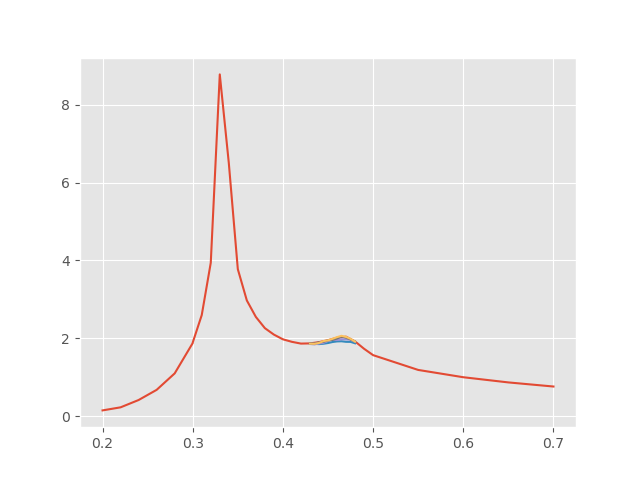

In [117]:
plt.figure()
c = [c for c in get_all_curves(["new-data/vsweeps/single/1/*/energy.dat"], prop="cv", skip=10000)]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c)

c = [c for c in get_all_curves(["new-data/temp/*/energy.dat"], prop="cv", skip=10000)]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c)

index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with

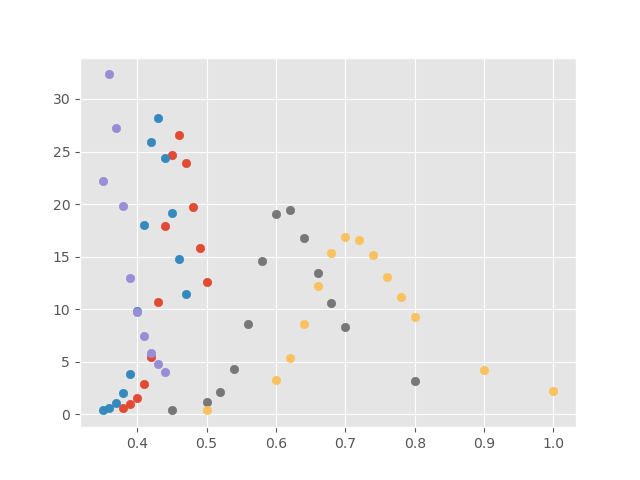

In [21]:
plt.figure()
for j in ["0.9", "0.8", "0.6", "1.5", "2"]:
    c = [c for c in get_all_curves([f"new-data/vsweeps/single/{j}/*/order.dat"], prop="ssus", skip=0)]
    colors = gen_colors(c)
    for a, b, c in c:
        plt.scatter(b, c)

# Figures

4


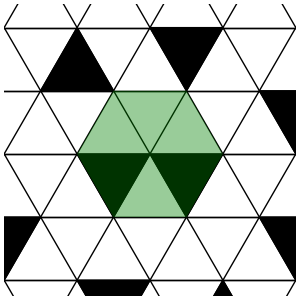

In [139]:
# Fig 1a 

fig, ax = plt.subplots(1, 1, figsize=[3, 3], layout="constrained")
show_positions(ax, [(3, 5, 1), (4, 5, 1), (2, 7, 0), (3, 7, 1), (5, 6, 1), (2, 4, 1), (4, 3, 1), (6, 3, 0), (6, 4, 1)], length=12, type="none")

ax.set_xlim([5, 9])
ax.set_ylim([3.25, 7.25])

ax.add_patch(matplotlib.patches.RegularPolygon(mono_coords(4, 6), 6, orientation=np.pi/6, radius=1, fc="green", alpha=0.4, zorder=3))

plt.savefig("figures/cluster.png")

0
0


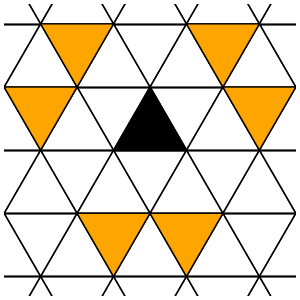

In [140]:
# Fig 1a 

fig, ax = plt.subplots(1, 1, figsize=[3, 3], layout="constrained")
show_positions(ax, [(5, 3, 0)], length=12, type="none")
show_positions(ax, [(3, 3, 1), (3, 4, 1), (6, 3, 1), (5, 4, 1), (5, 1, 1), (6, 1, 1)], length=12, type="none", color="orange")

ax.set_xlim([5, 9])
ax.set_ylim([0.6, 4.6])

plt.savefig("figures/j4.png")

11
11
0


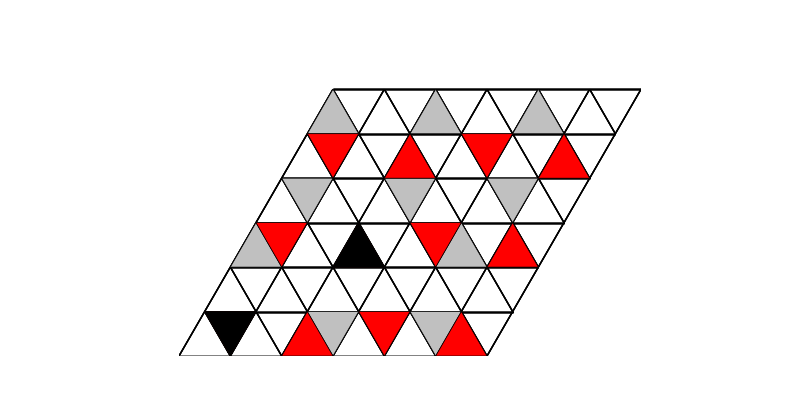

In [5]:
# Fig 1d
import pocket

positions = read_positions("new-data/6x6pos.dat", skip=0)

pos = positions[100]

fig, ax = plt.subplots(1, 1, figsize=[8, 4])

show_positions(ax, pos, length=6, type="none", color="silver")

pocket.width = 6
pocket.height = 6
sample = (pos, pocket.gen_occ(pos))
sample, moved = pocket.pocket_move(sample, seed=(2, 3, 1), sym=("R", (3, 3, 5)))

isect = list(set(sample[0]).intersection(set(pos)))

show_positions(ax, sample[0], length=6, type="none", color="red")
show_positions(ax, isect, length=6, type="none", color="black")

ax.set_xlim([0, 9])
ax.set_ylim([0, 6])

plt.savefig("figures/1a.png")

6
1
1


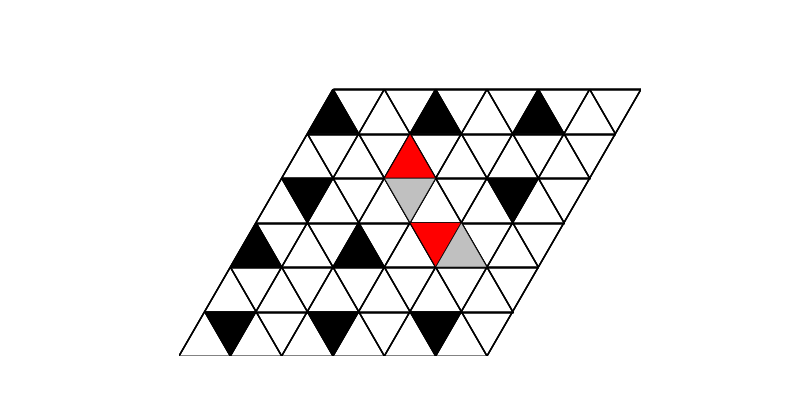

In [6]:
# Fig 1a 

fig, ax = plt.subplots(1, 1, figsize=[8, 4])

pos2, flipped = flip_line(pos, (5, 2), 6, 6, lim=2)
show_positions(ax, pos2, length=6, type="none", color="black")
show_positions(ax, flipped, length=6, type="none", color="red")

show_positions(ax, list(set(pos) - set(pos2)), length=6, type="none", color="silver")

ax.set_xlim([0, 9])
ax.set_ylim([0, 6])

plt.savefig("figures/1a.png")

6
3
3


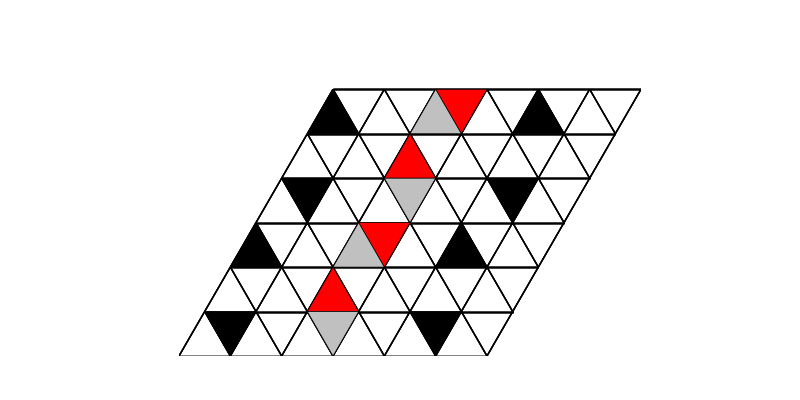

In [7]:
# Fig 1a 

fig, ax = plt.subplots(1, 1, figsize=[8, 4])

pos2, flipped = flip_line(pos, (3, 3), 6, 6, lim=10)
show_positions(ax, pos2, length=6, type="none", color="black")
show_positions(ax, flipped, length=6, type="none", color="red")

show_positions(ax, list(set(pos) - set(pos2)), length=6, type="none", color="silver")

ax.set_xlim([0, 9])
ax.set_ylim([0, 6])

plt.savefig("figures/1a.png")

5


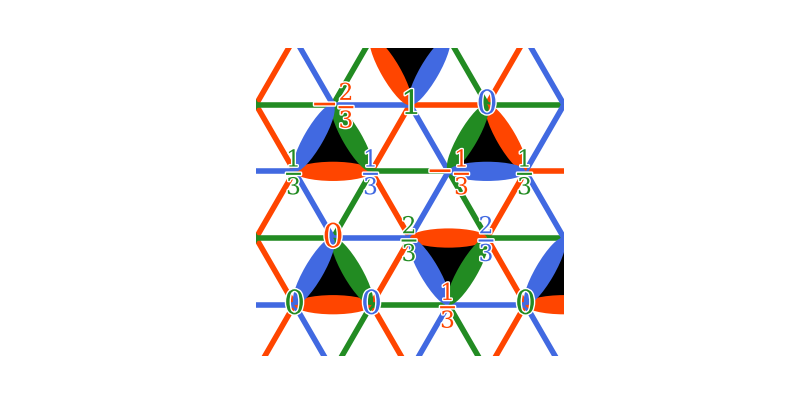

In [103]:
# Fig 1a 

fig, ax = plt.subplots(1, 1, figsize=[8, 4])

positions = [(3, 1, 0), (2, 3, 0), (2, 4, 1), (4, 3, 0), (4, 1, 1), (6, 1, 0)]

pos2, flipped = flip_line(pos, (3, 3), 6, 6, lim=10)
show_positions(ax, positions, length=12, type="none", color="black")

import matplotlib
for color, pos in [("orangered", (3, 1)), ("forestgreen", (4, 1)), ("royalblue", (5, 1))]:
    lines = []
    for dy in range(-1, 5):
        for dx in range(-6+dy, 5, 3):
            lines.append([mono_coords(pos[0]+dx, pos[1]+dy), mono_coords(pos[0]+dx+1, pos[1]+dy)])
            lines.append([mono_coords(pos[0]+dx, pos[1]+dy), mono_coords(pos[0]+dx-1, pos[1]+dy+1)])
            lines.append([mono_coords(pos[0]+dx, pos[1]+dy), mono_coords(pos[0]+dx, pos[1]+dy-1)])
    ax.add_collection(matplotlib.collections.LineCollection(lines, color=color, lw=4))

bonds = [[], [], []]
for x, y, s in positions:
    color = x + 2 * y + 0
    if s == 0:
        bonds[color%3].append(matplotlib.patches.Ellipse(mono_coords(x, y+0.5), width=1, height=0.25, angle=60))
        bonds[(color+1)%3].append(matplotlib.patches.Ellipse(mono_coords(x+0.5, y), width=1, height=0.25, angle=0))
        bonds[(color+2)%3].append(matplotlib.patches.Ellipse(mono_coords(x+0.5, y+0.5), width=1, height=0.25, angle=120))
    else:
        bonds[(color)%3].append(matplotlib.patches.Ellipse(mono_coords(x+0.5, y+1), width=1, height=0.25, angle=0))
        bonds[(color+1)%3].append(matplotlib.patches.Ellipse(mono_coords(x+1, y+0.5), width=1, height=0.25, angle=60))
        bonds[(color+2)%3].append(matplotlib.patches.Ellipse(mono_coords(x+0.5, y+0.5), width=1, height=0.25, angle=120))
ax.add_collection(matplotlib.collections.PatchCollection(bonds[0], fc="orangered", zorder=3))
ax.add_collection(matplotlib.collections.PatchCollection(bonds[1], fc="forestgreen", zorder=3))
ax.add_collection(matplotlib.collections.PatchCollection(bonds[2], fc="royalblue", zorder=3))

import matplotlib.patheffects
for ls, color in [
    ([
        ("$0$", (4, 1)), ("$\\frac{2}{3}$", (5, 2)), ("$\\frac{1}{3}$", (3, 3)), ("$0$", (4, 4))],
    "royalblue"),
    ([
        ("$0$", (3, 1)), ("$0$", (6, 1)), ("$\\frac{2}{3}$", (4, 2)), ("$\\frac{1}{3}$", (2, 3)), ("$1$", (3, 4)), ("$\\frac{1}{3}$", (5, 3))],
    "forestgreen"),
    ([
        ("$\\frac{1}{3}$", (5, 1)), ("$0$", (3, 2)), ("$-\\frac{2}{3}$", (2, 4)), ("$-\\frac{1}{3}$", (4, 3))],
    "orangered"),
    ]:
    for txt, pos in ls:
        pos = mono_coords(*pos)
        txt = plt.text(pos[0], pos[1], txt, size=24, color=color, horizontalalignment="center", verticalalignment="center", weight="bold")
        txt.set_path_effects([matplotlib.patheffects.withStroke(linewidth=2, foreground='w')])

ax.set_xlim([3, 7])
ax.set_ylim([0.2, 4.2])

plt.savefig("figures/1a.png")

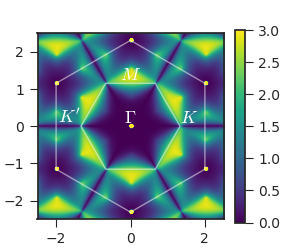

In [3]:
# data = read_accumulator("new-data/t0j0-ergodic/48x48_r-0_t0.000000_j0.000_50000000.10_0/tri-tri.dat")[0].reshape((48, 48, 2))
data = read_accumulator("new-data/t0j0-ergodic/120x120_r-0_t0.000000_j0.000_100000000.10_0/tri-tri.dat")[0].reshape((120, 120, 2))
data[0, 0, 0] = 1
fig, ax = plt.subplots(1, 1, figsize=[3, 2.5])
plot_FT(ax, FT(data), proj="abs", vmax=3)
plt.savefig("figures/liquidsf.png", dpi=200)

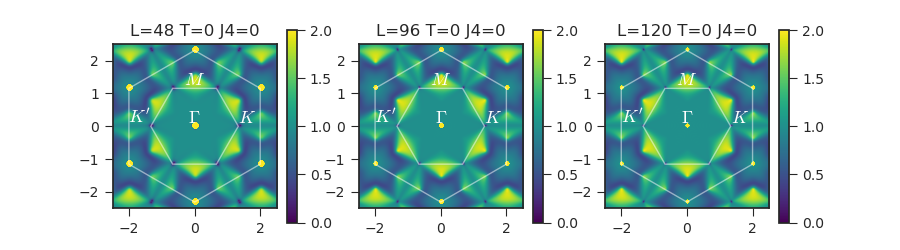

In [13]:
fig, ax = plt.subplots(1, 3, figsize=[9, 2.5])
ax[0].set_title("L=48 T=0 J4=0")
data = read_accumulator("new-data/t0j0-ergodic/48x48_r-0_t0.000000_j0.000_50000000.10_0/tri-tri.dat")[0].reshape((48, 48, 2))
plot_FT(ax[0], FT(data), proj="abs", vmax=2)

ax[1].set_title("L=96 T=0 J4=0")
data = read_accumulator("new-data/t0j0-ergodic/96x96_r-0_t0.000000_j0.000_50000000.10_0/tri-tri.dat")[0].reshape((96, 96, 2))
plot_FT(ax[1], FT(data), proj="abs", vmax=2)

ax[2].set_title("L=120 T=0 J4=0")
data = read_accumulator("new-data/t0j0-ergodic/120x120_r-0_t0.000000_j0.000_100000000.10_0/tri-tri.dat")[0].reshape((120, 120, 2))
plot_FT(ax[2], FT(data), proj="abs", vmax=2)

plt.savefig("figures/temp1.png", dpi=300)
# data = read_accumulator("new-data/finite-t-ergodic/0.2/48x48_r-3_t0.200000_j0.000_100000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))

In [62]:
kkdata[47, 1, ::3]

array([0.03560876, 0.09519759, 0.20239586])

In [46]:
np.max(data)

0.20218285714285714

In [46]:
data = autoshape(read_accumulator("new-data/dimers-hex/48x48/dimer-dimer.dat")[0], 9)
fig, ax = plt.subplots(1, 1)
plot_FT(ax, FT(data, coords=dimer_hex_coords, double=False, matrix=True), fold=True, proj="abs", res=50, vmax=5)

(48, 48, 9)


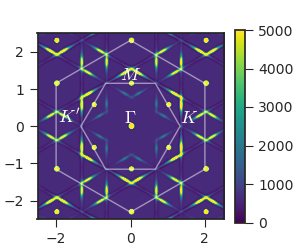

In [10]:
data = read_accumulator("data/idealbw/60x60_r-3_uinf_4j0.00_1000.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
fig, ax = plt.subplots(1, 1, figsize=[3, 2.5])
plot_FT(ax, FT(data), proj="abs", vmax=5000)
plt.savefig("figures/bwsf.png", dpi=200)

NameError: name 'FT_hex' is not defined

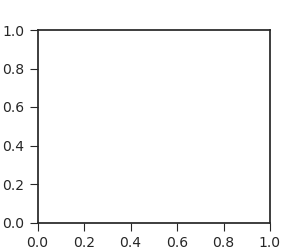

In [15]:
data = read_accumulator("new-data/temp/pt/48x48_r-3_t0.000100_uinf_j-1.000_50000000.10_0/tri-tri.dat")[0].reshape((48, 48, 2))
# data = read_accumulator("new-data/temp/48x48_r-3_t0.000000_j-1.000_1000000.10_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(1, 1, figsize=[3, 2.5])
plot_FT(ax, FT_hex(data), proj="logabs")
# plt.savefig("figures/bwsf.png", dpi=200)